# PREDICTION DES RETARDS DE VOL


## 1. IMPORT DES LIBRAIRIES


In [ ]:
import pandas as pd
from os.path import join
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb

## 2. CHARGEMENT DES DONNÉES


Les données sont réparties en 12 fichiers csv, un par mois de l'année 2016.  
Chaque fichier comporte plus de 470000 lignes. Cela représente un total de plus de 5,5 millions de lignes. Il nous faut donc trouver une stratégie pour épargner notre mémoire.


### 2.1. Exploration d'un unique (`2016_01.csv`)

Dans ce cadre, nous décidons de commencer par analyser un fichier pour identifier les optimisations possibles afin de les appliquer à tous les autres fichiers.


In [3]:
raw_data_path = join("..", "data", "raw")

jan_data_path = join(raw_data_path, "2016_01.csv")

In [4]:
df_jan = pd.read_csv(jan_data_path, on_bad_lines="warn", low_memory=False)
df_jan.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,TAIL_NUM,...,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,FIRST_DEP_TIME,TOTAL_ADD_GTIME,LONGEST_ADD_GTIME,Unnamed: 64
0,2016,1,1,6,3,2016-01-06,AA,19805,AA,N4YBAA,...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016,1,1,7,4,2016-01-07,AA,19805,AA,N434AA,...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016,1,1,8,5,2016-01-08,AA,19805,AA,N541AA,...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016,1,1,9,6,2016-01-09,AA,19805,AA,N489AA,...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016,1,1,10,7,2016-01-10,AA,19805,AA,N439AA,...,4,0.0,0.0,47.0,0.0,66.0,NaN,NaN,NaN,NaN


In [5]:
columns = df_jan.columns
columns

Index(['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE',
       'UNIQUE_CARRIER', 'AIRLINE_ID', 'CARRIER', 'TAIL_NUM', 'FL_NUM',
       'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID',
       'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_FIPS',
       'ORIGIN_STATE_NM', 'ORIGIN_WAC', 'DEST_AIRPORT_ID',
       'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 'DEST', 'DEST_CITY_NAME',
       'DEST_STATE_ABR', 'DEST_STATE_FIPS', 'DEST_STATE_NM', 'DEST_WAC',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15',
       'DEP_DELAY_GROUP', 'DEP_TIME_BLK', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP', 'ARR_TIME_BLK',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS', 'DISTANCE',
       'DISTANCE_GROUP', 'CARRIER_DELAY', 'WEATHER_DELAY

#### 2.1.1 Détermination de la cible

Nous avons identifié plusieurs candidats pour la cible : ARR_DELAY, ARR_DELAY_NEW, ARR_DEL15 et ARR_DELAY_GROUP


In [6]:
potential_targets = ["ARR_DELAY", "ARR_DELAY_NEW", "ARR_DEL15", "ARR_DELAY_GROUP"]

for target in potential_targets:
    print(f"{target}: Nombre de Valeurs Uniques")
    print("-" * 50)
    unique_count = df_jan[target].dropna().nunique()
    print(unique_count)
    if unique_count == 2:
        print(df_jan[target].dropna().unique())
    print("-" * 50)

ARR_DELAY: Nombre de Valeurs Uniques
--------------------------------------------------
735
--------------------------------------------------
ARR_DELAY_NEW: Nombre de Valeurs Uniques
--------------------------------------------------
660
--------------------------------------------------
ARR_DEL15: Nombre de Valeurs Uniques
--------------------------------------------------
2
[0. 1.]
--------------------------------------------------
ARR_DELAY_GROUP: Nombre de Valeurs Uniques
--------------------------------------------------
15
--------------------------------------------------


Nous constatons que seuls la colonne `ARR_DEL15` est sous forme binaire (en retard ou à l'heure) conformément à ce que nous souhaitons prédire. Les autres colonnes sont redondantes et peuvent donc être supprimées.


In [7]:
target = "ARR_DEL15"
redundant_targets = [col for col in potential_targets if col is not target]

print(redundant_targets)

['ARR_DELAY', 'ARR_DELAY_NEW', 'ARR_DELAY_GROUP']


Analysons cette colonne cible :


In [8]:
df_jan[target].info()

<class 'pandas.core.series.Series'>
RangeIndex: 445827 entries, 0 to 445826
Series name: ARR_DEL15
Non-Null Count   Dtype  
--------------   -----  
433298 non-null  float64
dtypes: float64(1)
memory usage: 3.4 MB


Nous constatons que le type de la colonne (float) n'est pas adapté. Il faudrait le transformer en bouléen.


In [9]:
target_na_count = df_jan[target].isna().sum()
print(f"{target_na_count} lignes vide pour la cible {target}")

12529 lignes vide pour la cible ARR_DEL15


In [10]:
for col in redundant_targets:
    na_count = df_jan[col].isna().sum()
    print(f"{na_count} lignes vide pour la colonne {col}")

12529 lignes vide pour la colonne ARR_DELAY
12529 lignes vide pour la colonne ARR_DELAY_NEW
12529 lignes vide pour la colonne ARR_DELAY_GROUP


In [11]:
all_na_mask = df_jan[potential_targets].isna().all(axis=1)
all_na_count = all_na_mask.sum()

print(f"Lignes où TOUTES les colonnes sont NA : {all_na_count}")

Lignes où TOUTES les colonnes sont NA : 12529


Nous constatons que plusieurs milliers de lignes n'ont pas de valeur cible. L'exploration des potentielles colonnes cibles précédemment écartées nous indique qu'il ne serait pas possible de reconstituer les valeurs manquantes avec ces autres colonnes.  
Il semble donc indispensable de les supprimer car ces lignes ne peuvent pas permettre d'entraîner le futur modèle.


#### 2.1.2. Identifications des colonnes aux valeurs manquantes


In [ ]:
na_percentages = (df_jan.isna().sum() / len(df_jan)) * 100

high_na_cols = na_percentages[na_percentages > 80].index.tolist()

print("Colonnes avec plus de 50% de valeurs manquantes :")
for col in high_na_cols:
    print(f"- {col}: {na_percentages[col]:.2f}%")

print(f"\nListe des colonnes ({len(high_na_cols)}) :")
print(high_na_cols)

Colonnes avec plus de 50% de valeurs manquantes :
- CANCELLATION_CODE: 97.38%
- CARRIER_DELAY: 84.10%
- WEATHER_DELAY: 84.10%
- NAS_DELAY: 84.10%
- SECURITY_DELAY: 84.10%
- LATE_AIRCRAFT_DELAY: 84.10%
- FIRST_DEP_TIME: 99.43%
- TOTAL_ADD_GTIME: 99.43%
- LONGEST_ADD_GTIME: 99.43%
- Unnamed: 64: 100.00%

Liste des colonnes (10) :
['CANCELLATION_CODE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'FIRST_DEP_TIME', 'TOTAL_ADD_GTIME', 'LONGEST_ADD_GTIME', 'Unnamed: 64']


Nous avons identifié les colonnes pour lesquelles plus de 80% des données sont manquantes. Sans analyse plus approfondie, nous pourrions nous dire que ces données sont inutilisables, car avec un tel taux de données manquantes, il serait hasardeux d'essayer d'imputer les valeurs manquantes sur aussi peu de données. Attardons nous cependant sur ces colonnes.

**Analyse colonne par colonne :**

- `Unnamed: 64`: 100.00% => colonne entièrement vide, probablement due à une virgule surnuméraire en fin de ligne. Colonne à supprimer définitivement.
- `CANCELLATION_CODE`: 97.38% => ici, nous supposons que les valeurs vides correspondent tout simplement à une absence de code d'annulation dans le cas où les vols ne sont pas annulés
  Les colonnes suivantes ne sont pas décrites dans le sujet d'examen. Nous pouvons cependant réaliser quelques suppositions :
- `CARRIER_DELAY`, `WEATHER_DELAY`, `NAS_DELAY`, `SECURITY_DELAY` et `LATE_AIRCRAFT_DELAY`: toutes à 84.10% => Nous supposons que les valeurs nulles correspondent aux vols non retardés
- `FIRST_DEP_TIME`, `TOTAL_ADD_GTIME` et `LONGEST_ADD_GTIME`: toutes à 99.43% => Nous supposons que les valeurs manquantes correspondent aux vols n'ont pas été détournés.

Nous allons analyser ces hypothèses.


In [18]:
mask_na = df_jan["CANCELLATION_CODE"].isna()
mask_is_not_cancelled = df_jan["CANCELLED"] == 0.0

if (mask_na == mask_is_not_cancelled).all():
    print(
        "Les valeurs NA de la colonne CANCELLATION_CODE correspondent aux vols non annulés."
    )
else:
    print(
        "Les valeurs NA de la colonne CANCELLATION_CODE ne correspondent pas aux vols non annulés."
    )
    print(df_jan[mask_na != mask_is_not_cancelled])


Les valeurs NA de la colonne CANCELLATION_CODE correspondent aux vols non annulés.


L'hypothèse selon laquelle Les valeurs NA de la colonne CANCELLATION_CODE correspondent aux vols non annulés est vérifiée. Il serait envisageable d'imputer les valeurs manquantes avec un 4e code d'annulation, correspondant virtuellement à une non-annulation.


In [ ]:
mask_all_na = (
    df_jan[
        [
            "CARRIER_DELAY",
            "WEATHER_DELAY",
            "NAS_DELAY",
            "SECURITY_DELAY",
            "LATE_AIRCRAFT_DELAY",
        ]
    ]
    .isna()
    .all(axis=1)
)

print(
    f"Nombre de lignes où toutes les colonnes de type de délai sont NA : {mask_all_na.sum()}"
)

mask_is_not_delayed = df_jan["ARR_DEL15"] == 0.0

if (mask_all_na == mask_is_not_delayed).all():
    print(
        "\nLes lignes où toutes les colonnes de type de délai sont NA correspondent aux vols non retardés."
    )
else:
    print("\nIl existe des exceptions :")
    print(
        df_jan[mask_all_na != mask_is_not_delayed][
            [
                "ARR_DELAY",
                "CARRIER_DELAY",
                "WEATHER_DELAY",
                "NAS_DELAY",
                "SECURITY_DELAY",
                "LATE_AIRCRAFT_DELAY",
                "ARR_DEL15",
            ]
        ]
    )

Nombre de lignes où toutes les colonnes de type de délai sont NA : 374945

Il existe des exceptions :
        ARR_DELAY  CARRIER_DELAY  WEATHER_DELAY  NAS_DELAY  SECURITY_DELAY  \
72            NaN            NaN            NaN        NaN             NaN   
79            NaN            NaN            NaN        NaN             NaN   
80            NaN            NaN            NaN        NaN             NaN   
81            NaN            NaN            NaN        NaN             NaN   
102           NaN            NaN            NaN        NaN             NaN   
...           ...            ...            ...        ...             ...   
445331        NaN            NaN            NaN        NaN             NaN   
445332        NaN            NaN            NaN        NaN             NaN   
445431        NaN            NaN            NaN        NaN             NaN   
445471        NaN            NaN            NaN        NaN             NaN   
445561        NaN            NaN        

A première vue, l'hypothèse selon laquelle les lignes où toutes les colonnes de type de délai sont NA correspondent aux vols non retardés, semble fausse. Cependant, les exceptions relevées semblent correspondre à des lignes où le statut en retard ou à l'heure est également indéterminé. Les Lignes où les deux masques correspondent pourraient être remplies avec des valeurs nulles (0min de retard pour cette cause).


In [32]:
mask_all_na = (
    df_jan[["FIRST_DEP_TIME", "TOTAL_ADD_GTIME", "LONGEST_ADD_GTIME"]]
    .isna()
    .all(axis=1)
)

print(
    f"Nombre de lignes où toutes les colonnes de type de time sont NA : {mask_all_na.sum()}"
)

mask_is_not_diverted = df_jan["DIVERTED"] == 0.0

if (mask_all_na == mask_is_not_diverted).all():
    print(
        "\nLes lignes où toutes les colonnes de type de délai sont NA correspondent aux vols non déviés."
    )
else:
    print("\nIl existe des exceptions :")
    print(
        df_jan[mask_all_na != mask_is_not_diverted][
            [
                "FIRST_DEP_TIME",
                "TOTAL_ADD_GTIME",
                "LONGEST_ADD_GTIME",
                "DIVERTED",
            ]
        ]
    )

Nombre de lignes où toutes les colonnes de type de time sont NA : 443275

Il existe des exceptions :
        FIRST_DEP_TIME  TOTAL_ADD_GTIME  LONGEST_ADD_GTIME  DIVERTED
70               642.0             11.0               11.0       0.0
305             1336.0             19.0               19.0       0.0
339             1053.0             12.0               12.0       0.0
346                NaN              NaN                NaN       1.0
397             1511.0             22.0               22.0       0.0
...                ...              ...                ...       ...
445302           903.0             16.0               16.0       0.0
445332             NaN              NaN                NaN       1.0
445431             NaN              NaN                NaN       1.0
445543           733.0             57.0               57.0       0.0
445561             NaN              NaN                NaN       1.0

[3384 rows x 4 columns]


Ici, l'hypothèse selon laquelle les lignes où toutes les colonnes de type de délai sont NA correspondent aux vols non déviés, semble fausse. Il semble donc hasardeux d'essayer d'imputer les valeurs manquantes.


#### 2.1.3. Identification des colonnes à risque de data leakage


Pour la suite de l'analyse, nous partirons du principe que le modèle s'attachera à prédire le retard d'un vol qui aura déjà décollé.

Parmis les colonnes restantes certaines contiennent des informations qui influencent directement le résultat et qui ne seront normalement pas présentes au moment de la prédiction :

- `ARR_TIME` : Heure réelle d'arrivée inconnues au moment de la prédiction
- `ARR_DELAY`, `ARR_DELAY_NEW`, `ARR_DEL15`, `ARR_DELAY_GROUP` : Variables cibles (à prédire)
- `WHEELS_ON`, `TAXI_IN` : Données post-départ
- `ACTUAL_ELAPSED_TIME`, `AIR_TIME` : Durées réelles inconnues a priori
- `CANCELLED` : Les vols annulés ne peuvent être à l'heure ou en retard
- `DIVERTED` : Statut du vol potentiellement inconnu au moment de la prédiction

Ces colonnes doivent donc être supprimées.


In [33]:
data_leakage_cols = [
    "ARR_TIME",
    "ARR_DELAY",
    "ARR_DELAY_NEW",
    "ARR_DELAY_GROUP",
    "WHEELS_ON",
    "TAXI_IN",
    "ACTUAL_ELAPSED_TIME",
    "AIR_TIME",
    "CANCELLED",
    "DIVERTED",
]

#### 2.1.4. Identification des colonnes redondantes


Parmi les colonnes restantes, nous identifions plusieurs colonnes redondantes entre elles :

- `ARR_TIME_BLK` et `ARR_TIME` sont redondantes. Nous conserverons `ARR_TIME` car il s'agit d'une valeur numérique continue plutôt que catégorielle, cela permettra plus de précision.
- `DEP_DELAY`, `DEP_DELAY_NEW`, `DEP_DEL15`, `DEP_DELAY_GROUP` et `DEP_TIME_BLK` représentent toutes les retard au départ. Nous conserverons `DEP_DELAY` car elle nous semble la plus précise de toutes ces valeurs : il s'agit d'une valeur numérique continue qui prend aussi en compte l'avance au départ (valeurs négatives) qui peut avoir une influence directe sur le retard à l'arrivée.
- `AIRLINE_ID`, `UNIQUE_CARRIER` et `CARRIER` représentent toutes trois une façon d'identifier les compagnies aériennes. Nous ne conserverons que `UNIQUE_CARRIER`.
- Parmis les identifiants multiples pour l'origine et la destination, les codes IATA présents dans `ORIGIN` et `DEST` sont suffisament précis pour identifier à eux seuls l'aéroport d'origine et celui de destination.
- `ORIGIN_STATE_NM` et `ORIGIN_STATE_ABR` sont clairement redondants, l'abréviation seule pourrait suffire. Cependant, toute l'information géographique peut être portée par `ORIGIN`.
- De la même façon, `DEST_STATE_NM` et `DEST_STATE_ABR` sont redondants. Même analyse que pour `ORIGIN`, ici nous ne conserverons que `DEST`.
- `DISTANCE` et `DISTANCE_GROUP` sont redondantes. Nous choisissons de conserver `DISTANCE` car il s'agit d'une valeur continue, plus facile à interpréter.


Les colonnes redondantes n'apportant pas plus d'information, pourront être supprimées.


In [51]:
redundant_cols = [
    # Arrival time related -> keeping ARR_TIME
    "ARR_TIME_BLK",
    # Departure related -> keeping DEP_DELAY
    "DEP_DELAY_NEW",
    "DEP_DEL15",
    "DEP_DELAY_GROUP",
    "DEP_TIME_BLK",
    # Airline/Carrier related -> keeping UNIQUE_CARRIER
    "AIRLINE_ID",
    "CARRIER",
    # Origin related -> keeping ORIGIN
    "ORIGIN_AIRPORT_ID",
    "ORIGIN_AIRPORT_SEQ_ID",
    "ORIGIN_CITY_MARKET_ID",
    "ORIGIN_STATE_FIPS",
    "ORIGIN_STATE_NM",
    "ORIGIN_WAC",
    "ORIGIN_CITY_NAME",
    "ORIGIN_STATE_ABR",
    # Destination related -> keeping DEST
    "DEST_AIRPORT_ID",
    "DEST_AIRPORT_SEQ_ID",
    "DEST_CITY_MARKET_ID",
    "DEST_STATE_FIPS",
    "DEST_STATE_NM",
    "DEST_WAC",
    "DEST_CITY_NAME",
    "DEST_STATE_ABR",
    # Distance related -> keeping DISTANCE
    "DISTANCE_GROUP",
]

#### 2.1.5. Analyse des colonnes temporelles


Parmi les colonnes temporelles (`YEAR`, `QUARTER`, `MONTH`, `DAY_OF_MONTH`,`DAY_OF_WEEK` et `FL_DATE`), il existe une certaine redondance.  
`FL_DATE` comporte toute l'information temporelle nécessaire en une seule colonne. Cependant, du point de vue du machine learning, il est plus facile de manipuler des valeurs numérique plutôt que des dates. Plusieurs stratégies s'offrent à nous :

- Tout conserver, mais cela ne semble pas très efficient,
- Ne conserver que `FL_DATE` dans notre future base de données et extraire les données temporelle en prétraitement
- Ne conserver que les données segmentées dans la base de données afin de les fournir directement lors de l'entrainement du modèle.


Nous choisirons la dernière méthode pour faciliter l'entraînement du modèle. Nous prenons églament le parti de supprimer la colonne `YEAR` car toutes nos données ne concernent que l'année 2016, cette colonne n'apporte donc aucune plus value à l'entraînement du modèle.


In [35]:
removable_temporal_cols = ["FL_DATE", "YEAR", "QUARTER"]

#### 2.1.6 Cas de la colonne `FLIGHTS`


In [36]:
df_jan["FLIGHTS"].value_counts()

FLIGHTS
1.0    445827
Name: count, dtype: int64

Nous constatons que cette colonne, qui n'est d'ailleurs pas décrite, ne comprend qu'une valeur unique. Elle n'est donc pas nécessaire à la suite de l'analyse.


In [37]:
useless_cols = ["FLIGHTS"]

#### 2.1.7. Cas de `FL_NUM` et de `TAIL_NUM`


In [45]:
fl_num_unique_count = df_jan["FL_NUM"].nunique()
tail_num_unique_count = df_jan["TAIL_NUM"].nunique()
print(f"nombre de valeurs uniques de FL_NUM: {fl_num_unique_count}")
print(f"nombre de valeurs uniques de TAIL_NUM: {tail_num_unique_count}")

nombre de valeurs uniques de FL_NUM: 6659
nombre de valeurs uniques de TAIL_NUM: 4238


Les numéros de vol et identifiants des appareils pourraient être pertinents dans notre prédiction. Cependant du fait du très grand nombre de catégorie et au vue de nos ressources limitées, nous les excluerons des colonnes à conserver pour notre modèle.


In [47]:
useless_cols += ["FL_NUM", "TAIL_NUM"]

### 2.2. Identification des colonnes à conserver

Maintenant que nous avons identifié toutes les colonnes à supprimer, nous allons pouvoir appliquer ce traitement à tous les fichiers fournis afin de les alléger et de pouvoir les traiter dans leur ensemble.


In [55]:
cols_to_drop = (
    redundant_targets
    + high_na_cols
    + data_leakage_cols
    + redundant_cols
    + removable_temporal_cols
    + useless_cols
)
cols_to_keep = [col for col in columns if col not in cols_to_drop]
target_col = "ARR_DEL15"

cols_to_keep

['MONTH',
 'DAY_OF_MONTH',
 'DAY_OF_WEEK',
 'UNIQUE_CARRIER',
 'ORIGIN',
 'DEST',
 'CRS_DEP_TIME',
 'DEP_TIME',
 'DEP_DELAY',
 'TAXI_OUT',
 'WHEELS_OFF',
 'CRS_ARR_TIME',
 'ARR_DEL15',
 'CRS_ELAPSED_TIME',
 'DISTANCE']

### 2.3. Conversion des fichiers `.csv` en `.parquet`

Pour des raison de performances nous nous servirons désormais de fichiers au format parquet. Nous allons commencé par convertir l'ensemble des fichiers `.csv` individuels, puis nous concatènerons les fichiers individuels en un seul fichier `.parquet` comportant toutes les lignes.


#### 2.3.1 Cas du mois d'avril

Le fichier contenant les données du mois d'avril 2016 semble plus corrompu que les autres. Nous lui appliquerons donc un traitement particulier.


In [ ]:
ap_data_path = join(raw_data_path, "2016_04.csv")
df_ap_clean = pd.read_csv(ap_data_path, on_bad_lines="warn", low_memory=False)
df_ap_clean.head()

/tmp/ipykernel_108987/769344222.py:2: ParserWarning: Skipping line 121012: expected 65 fields, saw 75
Skipping line 386249: expected 65 fields, saw 83
Skipping line 388291: expected 65 fields, saw 78
Skipping line 389371: expected 65 fields, saw 72
Skipping line 389548: expected 65 fields, saw 81
Skipping line 453858: expected 65 fields, saw 97

  df_ap_clean = pd.read_csv(


,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,TAIL_NUM,...,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,FIRST_DEP_TIME,TOTAL_ADD_GTIME,LONGEST_ADD_GTIME,Unnamed: 64
0,2016,2,4,3,7,2016-04-03,DL,19790,DL,N915DN,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016,2,4,3,7,2016-04-03,DL,19790,DL,N3755D,...,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016,2,4,3,7,2016-04-03,DL,19790,DL,N3755D,...,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016,2,4,3,7,2016-04-03,DL,19790,DL,N325US,...,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016,2,4,3,7,2016-04-03,DL,19790,DL,N366NB,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
df_ap_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479950 entries, 0 to 479949
Data columns (total 65 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   YEAR                   479950 non-null  object 
 1   QUARTER                479950 non-null  object 
 2   MONTH                  479950 non-null  int64  
 3   DAY_OF_MONTH           479950 non-null  object 
 4   DAY_OF_WEEK            479950 non-null  object 
 5   FL_DATE                479950 non-null  object 
 6   UNIQUE_CARRIER         479950 non-null  object 
 7   AIRLINE_ID             479950 non-null  int64  
 8   CARRIER                479950 non-null  object 
 9   TAIL_NUM               479185 non-null  object 
 10  FL_NUM                 479950 non-null  object 
 11  ORIGIN_AIRPORT_ID      479950 non-null  object 
 12  ORIGIN_AIRPORT_SEQ_ID  479950 non-null  int64  
 13  ORIGIN_CITY_MARKET_ID  479950 non-null  object 
 14  ORIGIN                 479950 non-nu

Nous constatons rapidement que des colonnes qui devraient être de type int ou float (comme pour le fichier de janvier) sont de type object, ce qui indique probablement un type mixte pour ces colonnes. Analysons quelques unes de ces colonnes problématiques.


In [62]:
cols_to_check = [
    "QUARTER",
    "DAY_OF_MONTH",
    "DAY_OF_WEEK",
    "FL_NUM",
    "CRS_DEP_TIME",
    "CRS_ARR_TIME",
    "ARR_TIME_BLK",
]

for col in cols_to_check:
    print("-" * 50)
    print(col)
    print("-" * 50)
    print(df_ap_clean[col].value_counts())

--------------------------------------------------
QUARTER
--------------------------------------------------
QUARTER
2     362831
1     117118
EV         1
Name: count, dtype: int64
--------------------------------------------------
DAY_OF_MONTH
--------------------------------------------------
DAY_OF_MONTH
25    18088
15    17894
29    17791
22    17762
21    17606
28    17398
27    17249
18    17077
20    17059
24    16783
14    16641
26    16330
6     16285
19    16254
17    15656
3     15608
23    15571
13    15188
8     15041
30    14990
1     14880
12    14874
4     14797
7     14741
11    14618
16    14581
5     14326
2     14002
10    13899
9     12570
31     4390
EV        1
Name: count, dtype: int64
--------------------------------------------------
DAY_OF_WEEK
--------------------------------------------------
DAY_OF_WEEK
5         76515
2         70534
4         69843
3         69261
1         66117
6         64559
7         63120
N707EV        1
Name: count, dtype: int64

Nous constatons certaines valeurs aberrantes parmi les valeurs uniques de certaines colonnes. Une seule ligne semble concernée à chaque fois. Regardons s'il s'agit toujours de la même ligne.


In [67]:
ev_rows = df_ap_clean[df_ap_clean["QUARTER"] == "EV"]
ev_rows

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,TAIL_NUM,...,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,FIRST_DEP_TIME,TOTAL_ADD_GTIME,LONGEST_ADD_GTIME,Unnamed: 64
461808,16-03-04,EV,20366,EV,N707EV,5059,10397,1039705,30397,ATL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
df_ap_clean = df_ap_clean.drop(index=461808)
df_ap_clean[df_ap_clean["QUARTER"] == "EV"]

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,TAIL_NUM,...,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,FIRST_DEP_TIME,TOTAL_ADD_GTIME,LONGEST_ADD_GTIME,Unnamed: 64


In [23]:
cols_to_check = [
    "QUARTER",
    "DAY_OF_MONTH",
    "DAY_OF_WEEK",
    "FL_NUM",
    "CRS_DEP_TIME",
    "CRS_ARR_TIME",
    "ARR_TIME_BLK",
]

for col in cols_to_check:
    print("-" * 50)
    print(col)
    print("-" * 50)
    print(df_ap_clean[col].value_counts())

--------------------------------------------------
QUARTER
--------------------------------------------------
QUARTER
2    362833
1    117122
Name: count, dtype: int64
--------------------------------------------------
DAY_OF_MONTH
--------------------------------------------------
DAY_OF_MONTH
25    18089
15    17895
29    17791
22    17762
21    17606
28    17398
27    17249
18    17077
20    17059
24    16783
14    16641
26    16330
6     16285
19    16254
17    15656
3     15608
23    15571
13    15188
8     15041
30    14990
1     14880
12    14874
4     14800
7     14741
11    14619
16    14581
5     14326
2     14002
10    13899
9     12570
31     4390
Name: count, dtype: int64
--------------------------------------------------
DAY_OF_WEEK
--------------------------------------------------
DAY_OF_WEEK
5    76518
2    70535
4    69843
3    69261
1    66119
6    64559
7    63120
Name: count, dtype: int64
--------------------------------------------------
FL_NUM
-------------------

Nous constatons qu'étrangement, ce fichier qui est censé ne concerner que le mois d'avril contient un nombre significatif des valeurs de `QUARTER` à 1 au lieu de 2.

**Hypothèse :** Certaines entrées du mois de mars ont été incluses dans les données du mois d'avril


In [69]:
coherence_check = ((df_ap_clean["MONTH"] == "3") & (df_ap_clean["QUARTER"] == "1")) | (
    (df_ap_clean["MONTH"] == "4") & (df_ap_clean["QUARTER"] == "2")
)

incoherent_rows = df_ap_clean[~coherence_check & df_ap_clean["MONTH"].isin(["3", "4"])]

print(f"Nombre de lignes incohérentes: {len(incoherent_rows)}")
if len(incoherent_rows) > 0:
    print("Échantillon des incohérences:")
    print(incoherent_rows[["MONTH", "QUARTER"]].head())

Nombre de lignes incohérentes: 0


L'hypothèse selon laquelle des lignes du mois de mars sont incluses dans les données du mois d'avril semble se vérifier dans la mesure où il existe une cohérence parfaite entre le mois et le semestre.


In [27]:
jan_float_cols = df_jan.select_dtypes(include=["float64", "float32"]).columns
ap_float_cols = df_ap_clean.select_dtypes(include=["float64", "float32"]).columns
print(len(jan_float_cols))
print(len(ap_float_cols))

30
3


#### 2.2.2. Création des fichiers `.parquet` individuels


In [ ]:
import pandas as pd
from os.path import join
import os

In [2]:
raw_data_path = join("..", "data", "raw")

In [3]:
cols_to_int = [
    "YEAR",
    "QUARTER",
    "MONTH",
    "DAY_OF_MONTH",
    "DAY_OF_WEEK",
    "AIRLINE_ID",
    "FL_NUM",
    "ORIGIN_AIRPORT_ID",
    "ORIGIN_AIRPORT_SEQ_ID",
    "ORIGIN_CITY_MARKET_ID",
    "ORIGIN_STATE_FIPS",
    "ORIGIN_WAC",
    "DEST_AIRPORT_ID",
    "DEST_AIRPORT_SEQ_ID",
    "DEST_CITY_MARKET_ID",
    "DEST_STATE_FIPS",
    "DEST_WAC",
    "CRS_DEP_TIME",
    "DEP_TIME",
    "DEP_DELAY",
    "DEP_DELAY_NEW",
    "DEP_DEL15",
    "DEP_DELAY_GROUP",
    "TAXI_OUT",
    "WHEELS_OFF",
    "WHEELS_ON",
    "TAXI_IN",
    "CRS_ARR_TIME",
    "ARR_TIME",
    "ARR_DELAY",
    "ARR_DELAY_NEW",
    "ARR_DEL15",
    "ARR_DELAY_GROUP",
    "CANCELLED",
    "DIVERTED",
    "CRS_ELAPSED_TIME",
    "ACTUAL_ELAPSED_TIME",
    "AIR_TIME",
    "FLIGHTS",
    "DISTANCE",
    "DISTANCE_GROUP",
    "CARRIER_DELAY",
    "WEATHER_DELAY",
    "NAS_DELAY",
    "SECURITY_DELAY",
    "LATE_AIRCRAFT_DELAY",
    "FIRST_DEP_TIME",
    "TOTAL_ADD_GTIME",
    "LONGEST_ADD_GTIME",
]

In [ ]:
for month in range(1, 13):
    data_path = join(raw_data_path, f"2016_{month:02}.csv")
    df = pd.read_csv(data_path, on_bad_lines="warn", low_memory=False)

    df = df.drop(columns=["Unnamed: 64"])

    if month == 4:
        df = df.drop(index=461814) # Ligne corrompue dans le fichier d'avril, colonnes décalées
        df = df[df["MONTH"] != 3] # Doublons du mois de mars dans le fichier d'avril

    for col in cols_to_int:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce").astype("Int64")

    parquet_path = data_path.replace(".csv", ".parquet")
    df.to_parquet(parquet_path)
    print(f"Converti : {data_path} -> {os.path.basename(parquet_path)}")

Converti : ../data/raw/2016_01.csv -> 2016_01.parquet
Converti : ../data/raw/2016_02.csv -> 2016_02.parquet
Converti : ../data/raw/2016_03.csv -> 2016_03.parquet


/tmp/ipykernel_9475/3032748337.py:3: ParserWarning: Skipping line 121012: expected 65 fields, saw 75
Skipping line 386249: expected 65 fields, saw 83
Skipping line 388291: expected 65 fields, saw 78
Skipping line 389371: expected 65 fields, saw 72
Skipping line 389548: expected 65 fields, saw 81
Skipping line 453858: expected 65 fields, saw 97

  df = pd.read_csv(data_path, on_bad_lines="warn", low_memory=False)


Converti : ../data/raw/2016_04.csv -> 2016_04.parquet
Converti : ../data/raw/2016_05.csv -> 2016_05.parquet
Converti : ../data/raw/2016_06.csv -> 2016_06.parquet
Converti : ../data/raw/2016_07.csv -> 2016_07.parquet
Converti : ../data/raw/2016_08.csv -> 2016_08.parquet
Converti : ../data/raw/2016_09.csv -> 2016_09.parquet
Converti : ../data/raw/2016_10.csv -> 2016_10.parquet
Converti : ../data/raw/2016_11.csv -> 2016_11.parquet
Converti : ../data/raw/2016_12.csv -> 2016_12.parquet


In [5]:
pd.set_option("display.max_rows", 65)
pd.set_option("display.max_columns", 65)

df_list = []
total_lines_count = 0

for month in range(1, 13):
    data_path = join(raw_data_path, f"2016_{month:02}.parquet")
    try:
        month_df = pd.read_parquet(data_path)
        df_list.append(month_df)
        lines_count = month_df.shape[0]
        total_lines_count += lines_count
        print(f"{lines_count} lines loaded from {data_path} ✅")
    except pd.errors.ParserError as err:
        print(f"ParserError for {data_path}: {err}")
    print("-" * 50)

print(f"For a total lines count of: {total_lines_count}")


445827 lines loaded from ../data/raw/2016_01.parquet ✅
--------------------------------------------------
423889 lines loaded from ../data/raw/2016_02.parquet ✅
--------------------------------------------------
479122 lines loaded from ../data/raw/2016_03.parquet ✅
--------------------------------------------------
362832 lines loaded from ../data/raw/2016_04.parquet ✅
--------------------------------------------------
479358 lines loaded from ../data/raw/2016_05.parquet ✅
--------------------------------------------------
487637 lines loaded from ../data/raw/2016_06.parquet ✅
--------------------------------------------------
502457 lines loaded from ../data/raw/2016_07.parquet ✅
--------------------------------------------------
498347 lines loaded from ../data/raw/2016_08.parquet ✅
--------------------------------------------------
454878 lines loaded from ../data/raw/2016_09.parquet ✅
--------------------------------------------------
472626 lines loaded from ../data/raw/2016_10.p

In [6]:
concat_df = pd.concat(df_list, ignore_index=True)

In [7]:
concat_df.to_parquet(join(raw_data_path, "complete.parquet"))

## 3. EXPLORATION ET VISUALISATION DES DONNÉES


### 3.1. Echantillonnage des données

In [ ]:
concat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5518860 entries, 0 to 5518859
Data columns (total 64 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   YEAR                   Int64 
 1   QUARTER                Int64 
 2   MONTH                  Int64 
 3   DAY_OF_MONTH           Int64 
 4   DAY_OF_WEEK            Int64 
 5   FL_DATE                object
 6   UNIQUE_CARRIER         object
 7   AIRLINE_ID             Int64 
 8   CARRIER                object
 9   TAIL_NUM               object
 10  FL_NUM                 Int64 
 11  ORIGIN_AIRPORT_ID      Int64 
 12  ORIGIN_AIRPORT_SEQ_ID  Int64 
 13  ORIGIN_CITY_MARKET_ID  Int64 
 14  ORIGIN                 object
 15  ORIGIN_CITY_NAME       object
 16  ORIGIN_STATE_ABR       object
 17  ORIGIN_STATE_FIPS      Int64 
 18  ORIGIN_STATE_NM        object
 19  ORIGIN_WAC             Int64 
 20  DEST_AIRPORT_ID        Int64 
 21  DEST_AIRPORT_SEQ_ID    Int64 
 22  DEST_CITY_MARKET_ID    Int64 
 23  DEST   

In [ ]:
concat_df.isna().sum()

YEAR                         1
QUARTER                      1
MONTH                        0
DAY_OF_MONTH                 1
DAY_OF_WEEK                  1
                        ...   
SECURITY_DELAY         4568715
LATE_AIRCRAFT_DELAY    4568715
FIRST_DEP_TIME         5485052
TOTAL_ADD_GTIME        5485052
LONGEST_ADD_GTIME      5485052
Length: 64, dtype: int64

In [ ]:
missing_count = concat_df[["DEP_TIME", "DEP_TIME_BLK"]].isnull().sum()

missing_percent = concat_df[["DEP_TIME", "DEP_TIME_BLK"]].isnull().mean() * 100

print("Nombre de valeurs manquantes :")
print(missing_count)
print("\nPourcentage de valeurs manquantes :")
print(missing_percent)

Nombre de valeurs manquantes :
DEP_TIME        62841
DEP_TIME_BLK        2
dtype: int64

Pourcentage de valeurs manquantes :
DEP_TIME        1.138659
DEP_TIME_BLK    0.000036
dtype: float64


Nous constatons qu'il manque plus de `DEP_TIME` que de `DEP_TIME_BLK`. Nous décidons de remplacer les valeurs manquantes de `DEP_TIME` par la moyenne des `DEP_TIME` pour le même `DEP_TIME_BLK`.


In [ ]:
df_retard = concat_df[concat_df["ARR_DEL15"] == 1]
df_ontime = concat_df[concat_df["ARR_DEL15"] == 0]

sample_size = 100000
n_per_class = int(sample_size / 2)

df_retard_sample = df_retard.sample(n=n_per_class, random_state=42)
df_ontime_sample = df_ontime.sample(n=n_per_class, random_state=42)

sample = (
    pd.concat([df_retard_sample, df_ontime_sample])
    .sample(frac=1, random_state=42)
    .reset_index(drop=True)
)

In [ ]:
sample.to_parquet(join(raw_data_path, "balanced_sample_100000.parquet"))

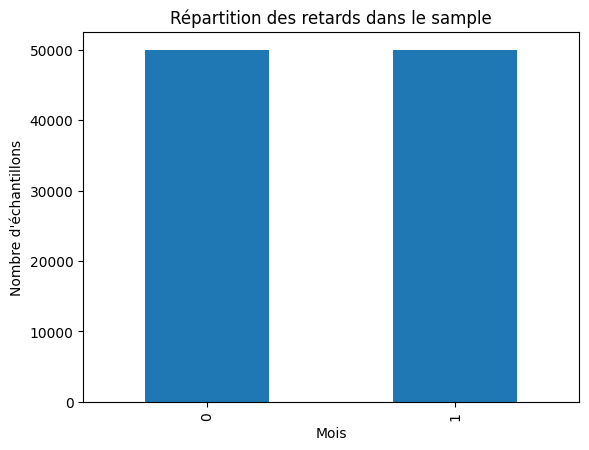

Moyenne des retards dans le sample complet: 0.50%


In [5]:
sample["ARR_DEL15"].value_counts().sort_index().plot(kind="bar")
plt.xlabel("Mois")
plt.ylabel("Nombre d'échantillons")
plt.title("Répartition des retards dans le sample")
plt.show()

mean_del_sample = sample["ARR_DEL15"].mean()
print(f"Moyenne des retards dans le sample complet: {mean_del_sample:.2f}%")

Le sample est bien équilibré.


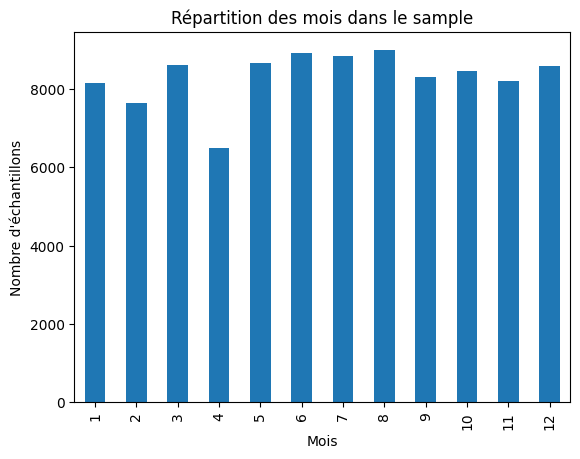

In [14]:
sample["MONTH"].value_counts().sort_index().plot(kind="bar")
plt.xlabel("Mois")
plt.ylabel("Nombre d'échantillons")
plt.title("Répartition des mois dans le sample")
plt.show()

Nous constatons une répartition uniforme des retards pour tous les mois. Cependant, nous observons qu'il y a moins de vols pour le mois d'avril, ce qui semble cohérent avec le fait que nous ayons dû enlever des doublons du mois de mars.


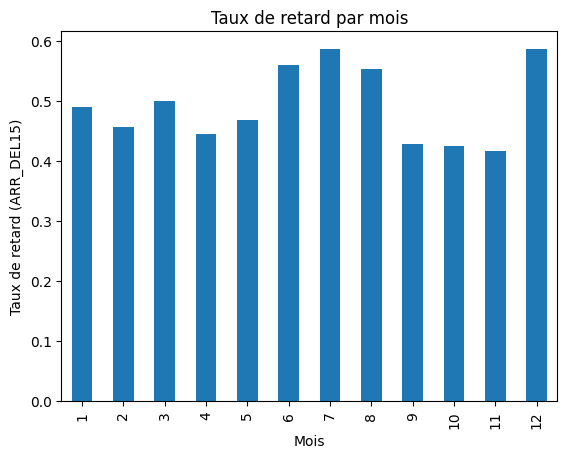

In [5]:
delay_by_month = sample.groupby("MONTH")["ARR_DEL15"].mean()

delay_by_month.plot(kind="bar")
plt.xlabel("Mois")
plt.ylabel("Taux de retard (ARR_DEL15)")
plt.title("Taux de retard par mois")
plt.show()

### 3.2 EXPLORATION ET VISUALISATION DES DONNÉES

Par essence, il n'est pas logique de réaliser l'analyse des données sur un dataset tronqué et qui plus est équilibré sur la cible. Les résultats ainsi obtenus ne peuvent pas être extrapolés à l'ensemble des données.  
Néanmoins, pour des raisons de mémoire insuffisante, nous poursuivrons sur l'échantillon.


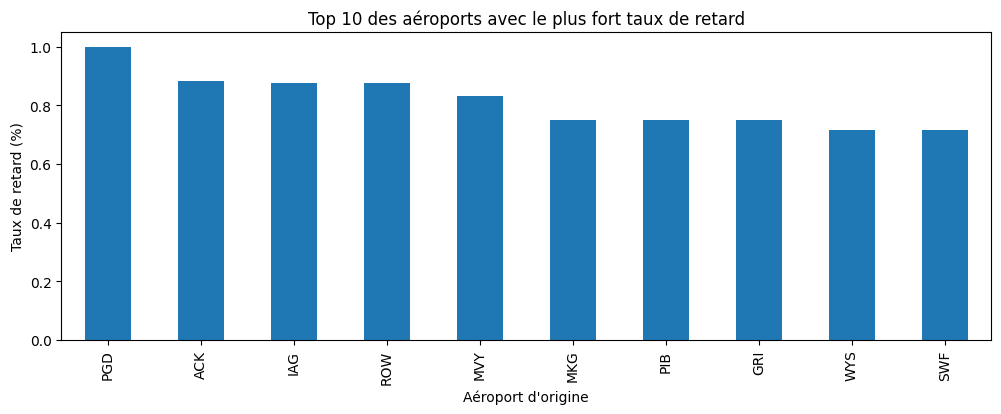

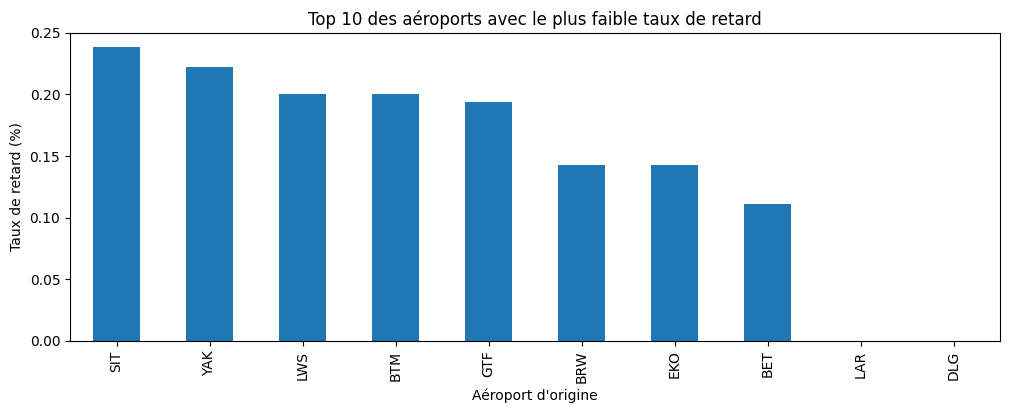

In [18]:
delay_by_airport = (
    sample.groupby("ORIGIN")["ARR_DEL15"].mean().sort_values(ascending=False)
)

delay_by_airport.head(10).plot(kind="bar", figsize=(12, 4))
plt.xlabel("Aéroport d'origine")
plt.ylabel("Taux de retard (%)")
plt.title("Top 10 des aéroports avec le plus fort taux de retard")
plt.show()

delay_by_airport.tail(10).plot(kind="bar", figsize=(12, 4))
plt.xlabel("Aéroport d'origine")
plt.ylabel("Taux de retard (%)")
plt.title("Top 10 des aéroports avec le plus faible taux de retard")
plt.show()

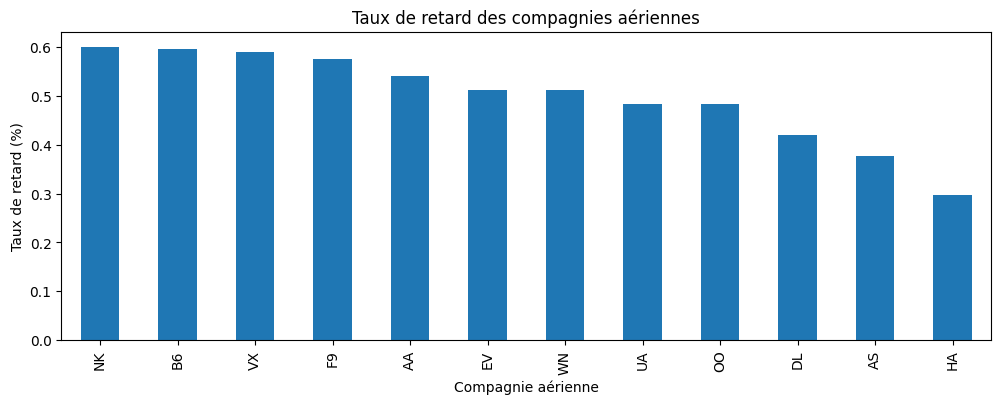

In [21]:
delay_by_carrier = (
    sample.groupby("CARRIER")["ARR_DEL15"].mean().sort_values(ascending=False)
)

delay_by_carrier.plot(kind="bar", figsize=(12, 4))
plt.xlabel("Compagnie aérienne")
plt.ylabel("Taux de retard (%)")
plt.title("Taux de retard des compagnies aériennes")
plt.show()

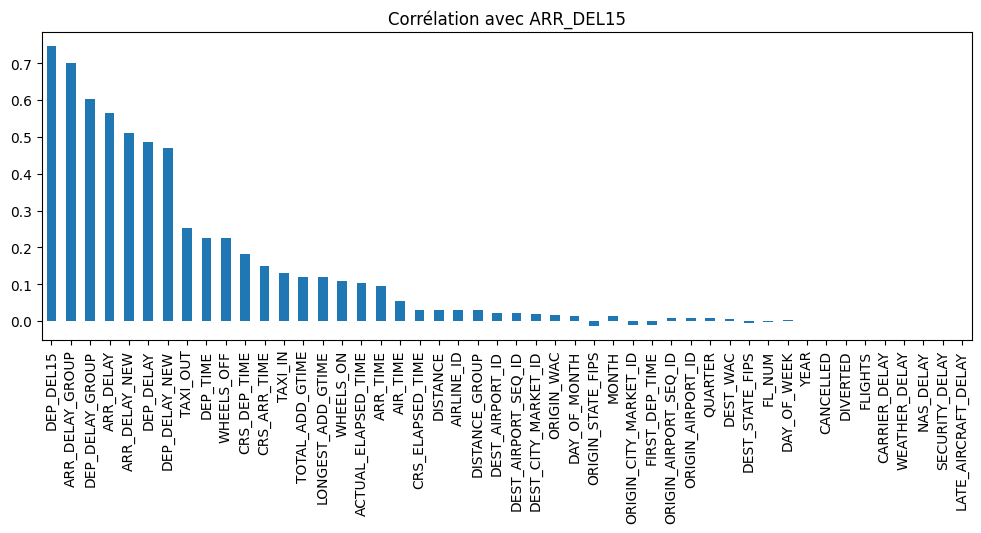

In [9]:
corr_matrix = sample.corr(numeric_only=True)
corr_target = (
    corr_matrix["ARR_DEL15"].drop("ARR_DEL15").sort_values(key=abs, ascending=False)
)

corr_target.plot(kind="bar", figsize=(12, 4), title="Corrélation avec ARR_DEL15")
plt.show()

Nous constatons que les colonnes concernant le retard au départ et à l'arrivée sont très fortement et de façon attendu à notre cible `ARR_DEL15`.


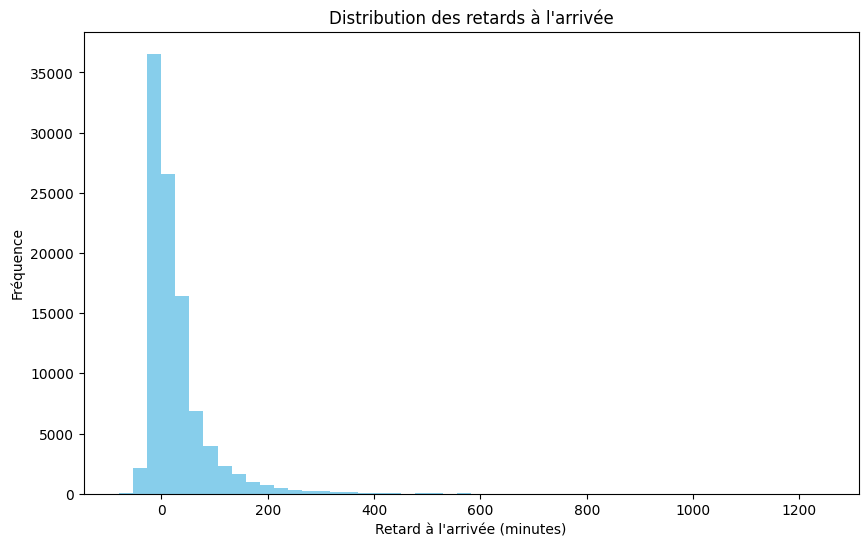

Statistiques descriptives des retards à l'arrivée:
mean      26.538880
median    14.500000
std       62.509688
Name: ARR_DELAY, dtype: float64


In [24]:
plt.figure(figsize=(10, 6))
plt.hist(sample["ARR_DELAY"].dropna(), bins=50, color="skyblue")
plt.xlabel("Retard à l'arrivée (minutes)")
plt.ylabel("Fréquence")
plt.title("Distribution des retards à l'arrivée")
plt.show()

stats = sample["ARR_DELAY"].agg(["mean", "median", "std"])
print("Statistiques descriptives des retards à l'arrivée:")
print(stats)

Nous constatons que la majorité des retards à l'arrivées sont de courte durée.

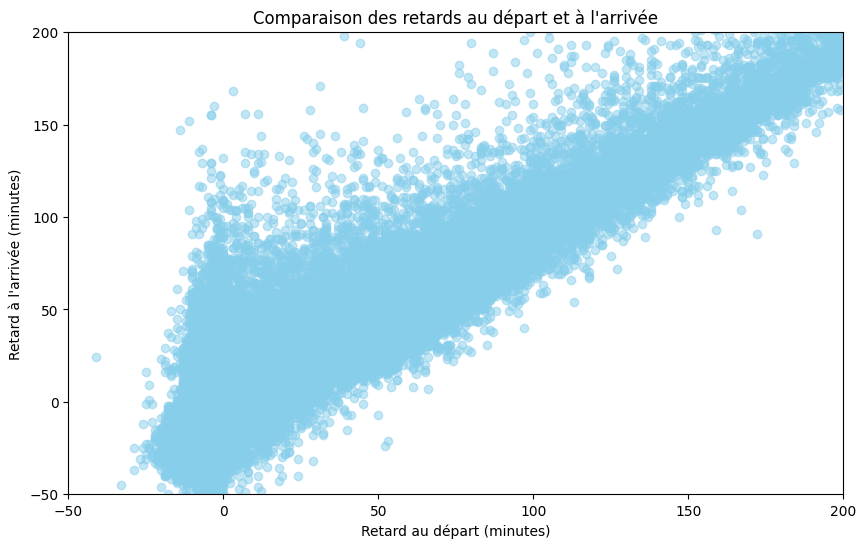

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(sample["DEP_DELAY"], sample["ARR_DELAY"], alpha=0.5, color="skyblue")
plt.xlabel("Retard au départ (minutes)")
plt.ylabel("Retard à l'arrivée (minutes)")
plt.title("Comparaison des retards au départ et à l'arrivée")
plt.xlim(-50, 200)
plt.ylim(-50, 200)
plt.show()

Nous observons que les retards à l'arrivée sont souvent corrélés avec les retards au départ, ce qui est logique.


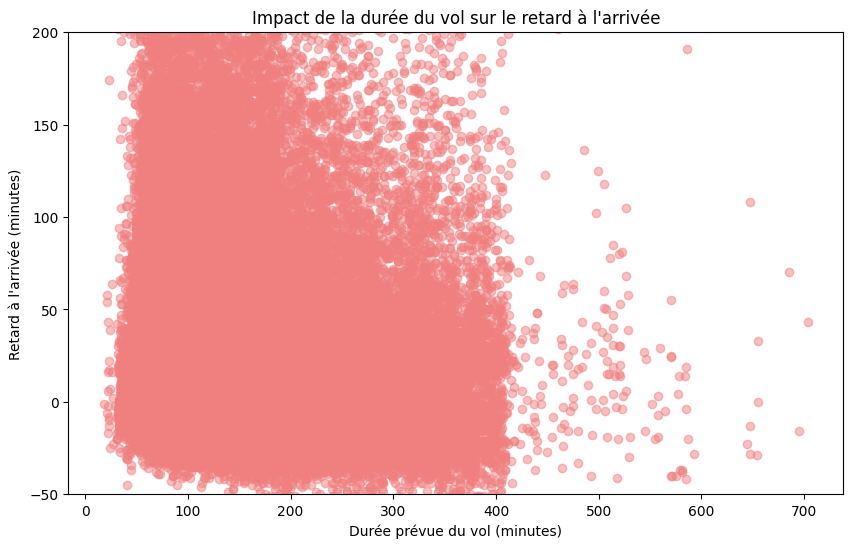

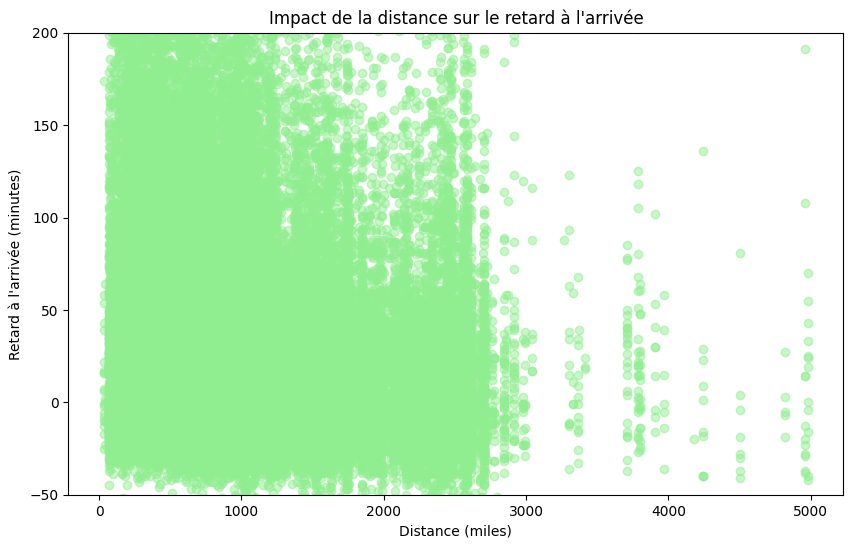

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(
    sample["CRS_ELAPSED_TIME"], sample["ARR_DELAY"], alpha=0.5, color="lightcoral"
)
plt.xlabel("Durée prévue du vol (minutes)")
plt.ylabel("Retard à l'arrivée (minutes)")
plt.title("Impact de la durée du vol sur le retard à l'arrivée")
plt.ylim(-50, 200)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(sample["DISTANCE"], sample["ARR_DELAY"], alpha=0.5, color="lightgreen")
plt.xlabel("Distance (miles)")
plt.ylabel("Retard à l'arrivée (minutes)")
plt.title("Impact de la distance sur le retard à l'arrivée")
plt.ylim(-50, 200)
plt.show()

On n'observe pas de corrélation évidente entre la durée prévue du vol ou la distance et le retard à l'arrivée. Cela peut indiquer que d'autres facteurs, tels que les conditions météorologiques ou la congestion du trafic aérien, jouent un rôle plus important dans les retards.


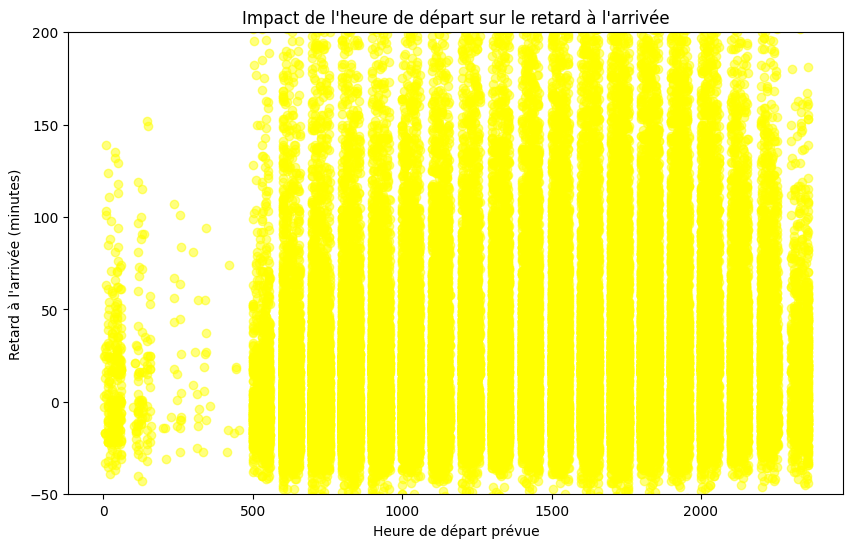

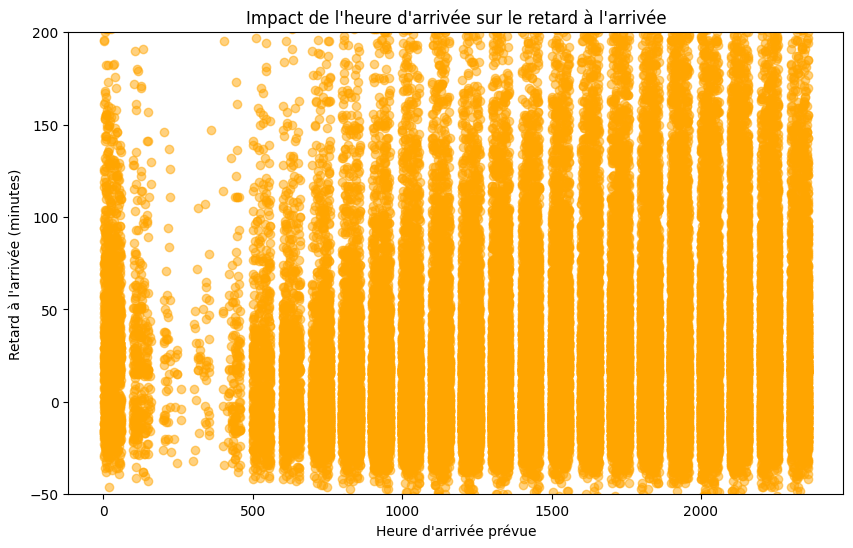

In [28]:
plt.figure(figsize=(10, 6))
plt.scatter(sample["CRS_DEP_TIME"], sample["ARR_DELAY"], alpha=0.5, color="yellow")
plt.xlabel("Heure de départ prévue")
plt.ylabel("Retard à l'arrivée (minutes)")
plt.title("Impact de l'heure de départ sur le retard à l'arrivée")
plt.ylim(-50, 200)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(sample["CRS_ARR_TIME"], sample["ARR_DELAY"], alpha=0.5, color="orange")
plt.xlabel("Heure d'arrivée prévue")
plt.ylabel("Retard à l'arrivée (minutes)")
plt.title("Impact de l'heure d'arrivée sur le retard à l'arrivée")
plt.ylim(-50, 200)
plt.show()

Nous n'observons pas de corrélation entre les retards et l'heure de départ ou d'arrivée. Nous constatons toutefois une réduction majeure des retards entre minuit et 5h00 du matin. Cela s'explique tout simplement par la réduction, voire la quasi absence, de vols décollant après minuit.

In [ ]:
origins = concat_df["ORIGIN"].unique().tolist()
dest = concat_df["DEST"].unique().tolist()

airports = pd.Series(origins + dest).unique().tolist()

print(f"Nombre total d'aéroports uniques: {len(airports)}")

Nombre total d'aéroports uniques: 312


In [ ]:
origin_states = concat_df["ORIGIN_STATE_ABR"].unique().tolist()
dest_states = concat_df["DEST_STATE_ABR"].unique().tolist()

states = pd.Series(origin_states + dest_states).unique().tolist()

print(f"Nombre total d'états uniques: {len(states)}")

Nombre total d'états uniques: 55


In [ ]:
origin_cities = concat_df["ORIGIN_CITY_NAME"].unique().tolist()
dest_cities = concat_df["ORIGIN_CITY_NAME"].unique().tolist()

cities = pd.Series(origin_cities + dest_cities).unique().tolist()

print(f"Nombre total de villes uniques: {len(cities)}")

Nombre total de villes uniques: 306


In [ ]:
airlines = concat_df["UNIQUE_CARRIER"].unique().tolist()

print(f"Nombre total de compagnies aériennes uniques: {len(airlines)}")

Nombre total de compagnies aériennes uniques: 12


## 5.MODÉLISATION


In [4]:
raw_data_path = join("..", "data", "raw")
sample_100000_path = join(raw_data_path, "balanced_sample_100000.parquet")
sample_250000_path = join(raw_data_path, "balanced_sample_250000.parquet")

In [5]:
df = pd.read_parquet(sample_100000_path)
df = df.drop(columns=["TAIL_NUM", "FL_NUM"])

In [ ]:
features = [
    "MONTH",             # num
    "DAY_OF_MONTH",      # num
    "DAY_OF_WEEK",       # num
    "UNIQUE_CARRIER",    # cat
    "ORIGIN",            # cat
    "DEST",              # cat
    "CRS_DEP_TIME",      # num
    "DEP_TIME",          # num
    "DEP_DELAY",         # num
    "TAXI_OUT",          # num
    "WHEELS_OFF",        # num
    "CRS_ARR_TIME",      # num
    "CRS_ELAPSED_TIME",  # num
    "DISTANCE",          # num
]
target = ["ARR_DEL15"]

In [ ]:
cat_features = ["UNIQUE_CARRIER", "ORIGIN", "DEST"]
num_features = [feat for feat in features if feat not in cat_features]

In [8]:
X = df[features]
y = df[target]

In [9]:
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=42
)

num_pipeline = Pipeline(
    [("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

cat_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

preprocessor = ColumnTransformer(
    [("num", num_pipeline, num_features), ("cat", cat_pipeline, cat_features)]
)

In [10]:
lr = LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced")

In [ ]:
full_pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", lr)])

param_grid = {
    "classifier__C": [0.01, 0.1, 1, 10, 100],
    "classifier__penalty": ["l1", "l2"],
    "classifier__solver": ["liblinear", "saga"],
    "classifier__class_weight": ["balanced", None],
}

grid_search = GridSearchCV(
    full_pipeline,
    param_grid,
    cv=5,
    n_jobs=-1,
    verbose=0,
)

In [ ]:
grid_search.fit(X_train, y_train.values.ravel())


print(f"Meilleurs paramètres : {grid_search.best_params_}")
print(f"Meilleur score CV : {grid_search.best_score_:.4f}")

# Meilleurs paramètres : {'classifier__C': 1, 'classifier__class_weight': None, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
# Meilleur score CV : 0.9118


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The ma

Meilleurs paramètres : {'classifier__C': 1, 'classifier__class_weight': None, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
Meilleur score CV : 0.9118


In [16]:
best_lr = grid_search.best_estimator_

y_pred_lr = best_lr.predict(X_test)
y_proba_lr = best_lr.predict_proba(X_test)

In [17]:
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print("-" * 60)
print("Évaluation du meilleur modèle")
print("-" * 60)
print(f"Précision : {lr_accuracy:.4f}")
print("\nRapport de classification :")
print(classification_report(y_test, y_pred_lr))

------------------------------------------------------------
Évaluation du meilleur modèle
------------------------------------------------------------
Précision : 0.9162

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.92     10078
         1.0       0.93      0.90      0.91      9922

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000



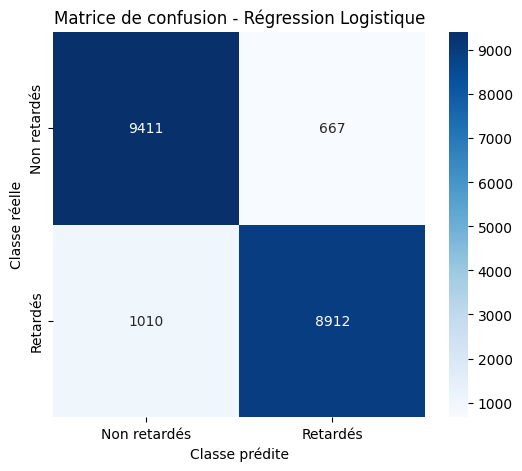

In [18]:
plt.figure(figsize=(6, 5))
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(
    cm_lr,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Non retardés", "Retardés"],
    yticklabels=["Non retardés", "Retardés"],
)
plt.title("Matrice de confusion - Régression Logistique")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()

#### LightGBM


In [23]:
lgbm = lgb.LGBMClassifier(random_state=42)


In [27]:
full_pipeline_lgbm = Pipeline([("preprocessor", preprocessor), ("classifier", lgbm)])

param_grid_lgbm = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__learning_rate": [0.01, 0.1, 0.2],
    "classifier__num_leaves": [31, 50, 70],
    "classifier__objective": ["binary"],
    "classifier__metric": ["binary_logloss"],
}

grid_search_lgbm = GridSearchCV(
    full_pipeline_lgbm, param_grid_lgbm, cv=3, n_jobs=-1, verbose=0
)

In [28]:
grid_search_lgbm.fit(X_train, y_train.values.ravel())

[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Start training from score 0.003938
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938
[LightGBM] [In

/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.235116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.166355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.271583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.197811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863
[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.168520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.130806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.120813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.118806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.128788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.240776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/

[LightGBM] [Info] Number of positive: 40078, number of negative: 39922
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2792
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 424
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900
Meilleurs paramètres LightGBM : {'classifier__learning_rate': 0.1, 'classifier__metric': 'binary_logloss', 'classifier__n_estimators': 300, 'classifier__num_leaves': 31, 'classifier__objective': 'binary'}
Meilleur score CV LightGBM : 0.9110


In [29]:
print(f"Meilleurs paramètres LightGBM : {grid_search_lgbm.best_params_}")
print(f"Meilleur score CV LightGBM : {grid_search_lgbm.best_score_:.4f}")

Meilleurs paramètres LightGBM : {'classifier__learning_rate': 0.1, 'classifier__metric': 'binary_logloss', 'classifier__n_estimators': 300, 'classifier__num_leaves': 31, 'classifier__objective': 'binary'}
Meilleur score CV LightGBM : 0.9110


In [30]:
best_lgbm = grid_search_lgbm.best_estimator_
y_pred_lgbm = best_lgbm.predict(X_test)
lgbm_accuracy = accuracy_score(y_test, y_pred_lgbm)

print("-" * 60)
print("Évaluation du meilleur modèle LightGBM")
print("-" * 60)
print(f"Précision LightGBM : {lgbm_accuracy:.4f}")
print("\nRapport de classification LightGBM :")
print(classification_report(y_test, y_pred_lgbm))

------------------------------------------------------------
Évaluation du meilleur modèle LightGBM
------------------------------------------------------------
Précision LightGBM : 0.9139

Rapport de classification LightGBM :
              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92     10078
         1.0       0.93      0.89      0.91      9922

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000



/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


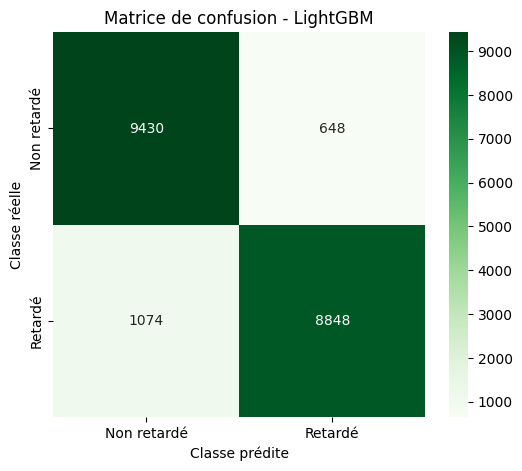

In [31]:
plt.figure(figsize=(6, 5))
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
sns.heatmap(
    cm_lgbm,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["Non retardé", "Retardé"],
    yticklabels=["Non retardé", "Retardé"],
)
plt.title("Matrice de confusion - LightGBM")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()

#### Random Forest


In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
rf = RandomForestClassifier(random_state=42)

In [34]:
full_pipeline_rf = Pipeline([("preprocessor", preprocessor), ("classifier", rf)])

# param_grid_rf = {
#     "classifier__n_estimators": [100, 200, 300],
#     "classifier__max_depth": [None, 10, 20, 30],
#     "classifier__min_samples_split": [2, 5, 10],
#     "classifier__min_samples_leaf": [1, 2, 4],
#     "classifier__class_weight": ["balanced", "balanced_subsample", None],
# }
param_grid_rf = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [10, 20],
    "classifier__min_samples_split": [2, 5],
    "classifier__min_samples_leaf": [1, 2],
    "classifier__class_weight": ["balanced", None],
}

grid_search_rf = GridSearchCV(
    full_pipeline_rf,
    param_grid_rf,
    cv=3,
    n_jobs=-1,
    verbose=0,
)

In [ ]:
grid_search_rf.fit(X_train, y_train.values.ravel())

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'classifier__class_weight': ['balanced', None], 'classifier__max_depth': [10, 20], 'classifier__min_samples_leaf': [1, 2], 'classifier__min_samples_split': [2, 5], ...}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [36]:
print(f"Meilleurs paramètres Random Forest : {grid_search_rf.best_params_}")
print(f"Meilleur score CV Random Forest : {grid_search_rf.best_score_:.4f}")

Meilleurs paramètres Random Forest : {'classifier__class_weight': None, 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Meilleur score CV Random Forest : 0.9018


In [37]:
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print("-" * 60)
print("Évaluation du meilleur modèle Random Forest")
print("-" * 60)
print(f"Précision Random Forest : {rf_accuracy:.4f}")
print("\nRapport de classification Random Forest :")
print(classification_report(y_test, y_pred_rf))


------------------------------------------------------------
Évaluation du meilleur modèle Random Forest
------------------------------------------------------------
Précision Random Forest : 0.9055

Rapport de classification Random Forest :
              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91     10078
         1.0       0.92      0.88      0.90      9922

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000



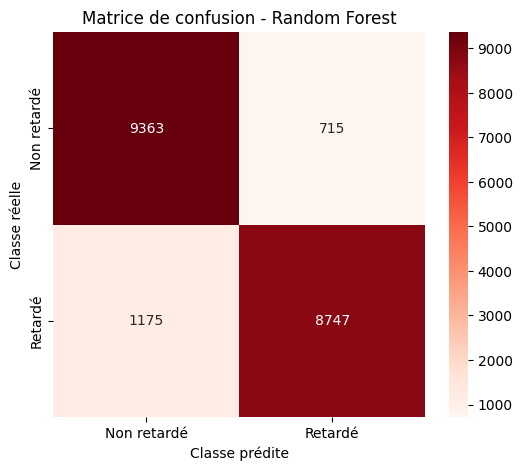

In [38]:
plt.figure(figsize=(6, 5))
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(
    cm_rf,
    annot=True,
    fmt="d",
    cmap="Reds",
    xticklabels=["Non retardé", "Retardé"],
    yticklabels=["Non retardé", "Retardé"],
)
plt.title("Matrice de confusion - Random Forest")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()

#### Comparaison des meilleurs modèles

**Régression Logistique**


In [40]:
best_lr = grid_search.best_estimator_
y_pred_lr = best_lr.predict(X_test)
y_proba_lr = best_lr.predict_proba(X_test)
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr)
lr_recall = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)
lr_auc = roc_auc_score(y_test, y_proba_lr[:, 1])

print("-" * 60)
print("Évaluation de la régression logistique")
print("-" * 60)
print(f"Précision : {lr_accuracy:.4f}")
print(f"Precision : {lr_precision:.4f}")
print(f"Recall : {lr_recall:.4f}")
print(f"F1-score : {lr_f1:.4f}")
print(f"AUC-ROC : {lr_auc:.4f}")
print("\nRapport de classification :")
print(classification_report(y_test, y_pred_lr))

------------------------------------------------------------
Évaluation de la régression logistique
------------------------------------------------------------
Précision : 0.9162
Precision : 0.9304
Recall : 0.8982
F1-score : 0.9140
AUC-ROC : 0.9670

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.92     10078
         1.0       0.93      0.90      0.91      9922

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000



**LightGBM**


In [41]:
best_lgbm = grid_search_lgbm.best_estimator_
y_pred_lgbm = best_lgbm.predict(X_test)
y_proba_lgbm = best_lgbm.predict_proba(X_test)
lgbm_accuracy = accuracy_score(y_test, y_pred_lgbm)
lgbm_precision = precision_score(y_test, y_pred_lgbm)
lgbm_recall = recall_score(y_test, y_pred_lgbm)
lgbm_f1 = f1_score(y_test, y_pred_lgbm)
lgbm_auc = roc_auc_score(y_test, y_proba_lgbm[:, 1])

print("-" * 60)
print("Évaluation de LightGBM")
print("-" * 60)
print(f"Précision : {lgbm_accuracy:.4f}")
print(f"Precision : {lgbm_precision:.4f}")
print(f"Recall : {lgbm_recall:.4f}")
print(f"F1-score : {lgbm_f1:.4f}")
print(f"AUC-ROC : {lgbm_auc:.4f}")
print("\nRapport de classification :")
print(classification_report(y_test, y_pred_lgbm))

/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


------------------------------------------------------------
Évaluation de LightGBM
------------------------------------------------------------
Précision : 0.9139
Precision : 0.9318
Recall : 0.8918
F1-score : 0.9113
AUC-ROC : 0.9700

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92     10078
         1.0       0.93      0.89      0.91      9922

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000



**Random Forest**


In [42]:
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_auc = roc_auc_score(y_test, y_proba_rf[:, 1])

print("-" * 60)
print("Évaluation de Random Forest")
print("-" * 60)
print(f"Précision : {rf_accuracy:.4f}")
print(f"Precision : {rf_precision:.4f}")
print(f"Recall : {rf_recall:.4f}")
print(f"F1-score : {rf_f1:.4f}")
print(f"AUC-ROC : {rf_auc:.4f}")
print("\nRapport de classification :")
print(classification_report(y_test, y_pred_rf))

------------------------------------------------------------
Évaluation de Random Forest
------------------------------------------------------------
Précision : 0.9055
Precision : 0.9244
Recall : 0.8816
F1-score : 0.9025
AUC-ROC : 0.9545

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91     10078
         1.0       0.92      0.88      0.90      9922

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000



In [44]:
print("-" * 70)
print("Tableau récapitulatif des scores des modèles")
print("-" * 70)
print(
    "{:<15} {:<10} {:<10} {:<10} {:<10} {:<10}".format(
        "Modèle", "Accuracy", "Precision", "Recall", "F1-score", "AUC-ROC"
    )
)
print("-" * 70)
print(
    "{:<15} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}".format(
        "Logistic Reg.", lr_accuracy, lr_precision, lr_recall, lr_f1, lr_auc
    )
)
print(
    "{:<15} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}".format(
        "LightGBM", lgbm_accuracy, lgbm_precision, lgbm_recall, lgbm_f1, lgbm_auc
    )
)
print(
    "{:<15} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}".format(
        "Random Forest", rf_accuracy, rf_precision, rf_recall, rf_f1, rf_auc
    )
)
print("-" * 70)

----------------------------------------------------------------------
Tableau récapitulatif des scores des modèles
----------------------------------------------------------------------
Modèle          Accuracy   Precision  Recall     F1-score   AUC-ROC   
----------------------------------------------------------------------
Logistic Reg.   0.9162     0.9304     0.8982     0.9140     0.9670    
LightGBM        0.9139     0.9318     0.8918     0.9113     0.9700    
Random Forest   0.9055     0.9244     0.8816     0.9025     0.9545    
----------------------------------------------------------------------


#### Conclusion


Les résultats des différents modèles sont très proches.  
Les très bonnes performances de la régression logistique (premier pour l'_accuracy_, le _recall_ et le _F1-score_) sont mêmes surprenantes et s'expliquent peut être par le fait que nous avons travaillé sur un échantillon réduit des données.  
Bien que la régression logistique présente des performances légèrement supérieures en termes d'_accuracy_, de _recall_ et de _F1-score_, LightGBM se distingue par une meilleure _précision_ et un _AUC-ROC_ plus élevés. Considérant que les écarts entre les deux modèles sont minimes sur les autres métriques, nous privilégions **LightGBM** en raison de son efficacité en termes de temps d'entraînement notamment sur de gros dataset, ce qui sera notre cas.
